In [ ]:
openai_key=""

In [55]:
import os, json, time, math
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

from openai import OpenAI

In [56]:
def read_csv_flexible(path: str, encodings=None, **kwargs) -> pd.DataFrame:
    encodings = encodings or ["utf-8", "utf-8-sig", "utf-16", "cp1252", "latin1"]
    if "sep" not in kwargs:
        kwargs["sep"] = None  # let Python engine sniff delimiters
    if "engine" not in kwargs:
        kwargs["engine"] = "python"

    errors = []
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except (UnicodeDecodeError, UnicodeError) as exc:
            errors.append(f"{enc}: {exc}")
        except pd.errors.ParserError as exc:
            errors.append(f"{enc}: {exc}")
    raise ValueError(
        "Failed to load CSV. Tried encodings: " + "; ".join(encodings) + ".\n" + " | ".join(errors)
    )



In [71]:
def read_excel_any(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine="openpyxl")
    df.columns = [c.strip().lower() for c in df.columns]
    colmap = {}
    if "prompt" in df.columns: colmap["prompt"] = "prompt"
    if "user" in df.columns: colmap["user"] = "prompt"
    if "question" in df.columns: colmap["question"] = "prompt"
    if "prediction" in df.columns: colmap["prediction"] = "prediction"
    if "response" in df.columns: colmap["response"] = "prediction"
    if "gold" in df.columns: colmap["gold"] = "gold"

    df = df.rename(columns=colmap)

    if "prediction" not in df.columns:
        raise ValueError(f"{path} missing required column for model output (prediction/response)")

    if "prompt" not in df.columns:
        raise ValueError(f"{path} missing required prompt column")

    if "gold" not in df.columns:
        df["gold"] = ""

    return df[["prompt","gold","prediction"]].copy()

In [72]:
def _model_from_filename(fname: str) -> str:
    stem = Path(fname).stem  
    return "QWEN3_4B instruct base" if stem == "predictions_real1" else stem

In [73]:
# Fill the list with dictionaries containing at least `prompt` and `answer` keys.
# Example:
# MANUAL_INPUTS = [
#     {
#         "prompt": "How can seniors stay safe during heat waves?",
#         "answer": "Stay hydrated, keep living spaces cool, and consult a doctor if symptoms appear.",
#         "model": "my-experiment",
#         "run": 1,
#         # "gold": "Drink water frequently, stay indoors, seek medical help if dizzy."
#     }
# ]
MANUAL_INPUTS = []
PROMPT_RESPONSE_CSV = "P_R1.xlsx"



In [74]:
def _uniq_preserve(seq):
    seen, out = set(), []
    for x in seq:
        s = "" if pd.isna(x) else str(x)
        if s and s not in seen:
            seen.add(s)
            out.append(s)
    return out

frames = []
if MANUAL_INPUTS:
    for idx, item in enumerate(MANUAL_INPUTS, start=1):
        prompt = item.get("prompt") or item.get("question")
        answer = item.get("answer") or item.get("output")
        if prompt is None or answer is None:
            raise ValueError("Each manual input needs `prompt` and `answer` (or `output`).")
        row = {
            "prompt": prompt,
            "gold": item.get("gold", ""),
            "prediction": answer,
            "__source_file__": item.get("model", "manual_input"),
            "__manual_run__": item.get("run"),
        }
        frames.append(pd.DataFrame([row]))
elif Path(PROMPT_RESPONSE_CSV).exists():
    source_path = Path(PROMPT_RESPONSE_CSV)
    if source_path.suffix.lower() in {".xlsx", ".xls"}:
        df = read_excel_any(source_path)
    else:
        df = read_csv_flexible(PROMPT_RESPONSE_CSV)
        lower_map = {c.lower().strip(): c for c in df.columns}
        prompt_col = next((lower_map[k] for k in ("prompt", "question") if k in lower_map), None)
        answer_col = next((lower_map[k] for k in ("answer", "response", "output") if k in lower_map), None)
        if prompt_col is None or answer_col is None:
            raise ValueError(f"`{PROMPT_RESPONSE_CSV}` must include a prompt column and an answer/response column.")
        df = df.rename(columns={
            prompt_col: "prompt",
            answer_col: "prediction",
        })
        if "gold" not in df.columns:
            df["gold"] = ""
    df["__source_file__"] = str(source_path)
    frames.append(df[["prompt", "gold", "prediction", "__source_file__"]])
else:
    if "DATA_FILES" not in globals():
        raise ValueError("Provide prompt/response CSV, define DATA_FILES (list of files), or populate MANUAL_INPUTS before running this cell.")
    for f in DATA_FILES:
        df = read_excel_any(f)
        df["__source_file__"] = f
        frames.append(df)

if not frames:
    raise ValueError("No data loaded. Provide a CSV, spreadsheet paths in DATA_FILES, or manual entries in MANUAL_INPUTS.")

In [75]:
df_raw = pd.concat(frames, ignore_index=True)

# Derive identifiers expected downstream
if "__manual_run__" in df_raw.columns:
    manual_runs = pd.to_numeric(df_raw["__manual_run__"], errors="coerce")
    df_raw["run"] = manual_runs.fillna(1).astype(int)
else:
    df_raw["run"] = 1

df_raw["model"] = df_raw["__source_file__"].astype(str)
df_raw["prompt_id"] = df_raw.groupby("__source_file__").cumcount()
df_raw["set_id"] = df_raw["__source_file__"].astype(str)
df_raw["prompt_text"] = df_raw["prompt"]
df_raw["output"] = df_raw["prediction"]


df_raw = df_raw.drop(columns=["__manual_run__"], errors="ignore")

tidy = df_raw[["set_id","prompt_id","model","run","output","prompt_text"]].copy()

print(f"Prepared prompt-response pairs for judging.")
tidy.head()


Prepared prompt-response pairs for judging.


,set_id,prompt_id,model,run,output,prompt_text
0,P_R1.xlsx,0,P_R1.xlsx,1,✅ I logged your **chicken** intake and **parac...,I ate chicken and took 50mg of paracetamol at ...
1,P_R1.xlsx,1,P_R1.xlsx,1,✅ I logged your **apple** intake and **fentany...,I ate apple and took 20 mcg of fentanyl at 2pm...
2,P_R1.xlsx,2,P_R1.xlsx,1,✅ I logged your **beef pasta** intake and **as...,I ate beef pasta and took 40mg of aspirin at 5...
3,P_R1.xlsx,3,P_R1.xlsx,1,✅ I’ve logged your **spinach** (taken at 5pm) ...,I ate spinach and took 40mg of calcium at 5pm ...
4,P_R1.xlsx,4,P_R1.xlsx,1,✅ I logged your pineapple intake and oxycodone...,I ate salmon and took 2 liters of alcohol at 5...


In [76]:
len(tidy)

12

# Calling 

In [52]:
assert "tidy" in globals(), "Expect a DataFrame named `tidy`."
need = {"set_id","prompt_id","model","run","output","prompt_text"}
missing = need - set(tidy.columns)
assert not missing, f"`tidy` is missing columns: {missing}"

client = OpenAI(api_key=openai_key)
JUDGE_MODEL = "gpt-5-nano"     # nano judge
TEMPERATURE = 0.0              # Openai baned 

SYSTEM_PROMPT = (
"You are an expert evaluator of writing quality.\n" 
"Evaluate ONLY from the given question and the answer—no external references or tools.\n" 
"Focus on grammar, fluency, readability, and style appropriateness; penalize awkward phrasing, unclear sentences, inconsistent tone, or register mismatches.\n"
"Do NOT judge factual correctness or domain accuracy.\n" 
"Output MUST match the schema."
)

In [53]:
USER_TEMPLATE = """\
Rubric (each 0–3): 
[Coherence & Relevance] 
0: The response is off-topic or so disorganized that the main idea is unclear. 
1: The response is partly relevant, but there are jumps in logic or weak connections between sentences. 
2: The response is generally relevant and coherent, with only minor lapses in flow. 
3: The response is fully relevant to the prompt and logically ordered throughout. 
[Grammar, Fluency & Readability] 
0: Very hard to read; frequent grammatical errors or broken sentences. 
1: Understandable, but contains several grammar/wording issues. 
2: Clear, with only a few minor errors or slightly awkward phrasing. 
3: Very clear and natural; no noticeable grammar or phrasing errors. 
[Style Appropriateness] 
0: Style/tone is clearly inappropriate (too casual, wrong register, inconsistent). 
1: Mostly appropriate, but with noticeable slips in tone or formality. 
2: Appropriate tone and vocabulary; minor improvements possible (e.g. conciseness). 
3: Consistently appropriate, concise, and professional (matches requested style exactly). 
Question (prompt): 
{prompt} Model answer:
{answer} Instructions: Provide integer scores in [0,3] for Coherence & Relevance,
Grammar/Fluency/Readability, and Style Appropriateness. 
Sum them to a total in [0,9]. 
Provide a brief explanation (<120 words) for each dimension.
"""

In [16]:
JSON_SCHEMA = {
    "name": "EvalScores",
    "strict": True,
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "coherence_relevance": {"type": "integer", "minimum": 0, "maximum": 3},
            "fluency_readability": {"type": "integer", "minimum": 0, "maximum": 3},
            "grammar_fluency_readability": {"type": "integer", "minimum": 0, "maximum": 3},
            "style_appropriateness": {"type": "integer", "minimum": 0, "maximum": 3},
            "total": {"type": "integer", "minimum": 0, "maximum": 9},
            "total_score": {"type": "integer", "minimum": 0, "maximum": 9},
            "explanations": {
                "type": "object",
                "additionalProperties": False,
                "properties": {
                    "coherence_relevance": {"type": "string"},
                    "fluency_readability": {"type": "string"},
                    "grammar_fluency_readability": {"type": "string"},
                    "style_appropriateness": {"type": "string"}
                },
                "required": ["coherence_relevance", "style_appropriateness"]
            }
        },
        "required": [
            "coherence_relevance",
            "style_appropriateness",
            "explanations"
        ],
        "allOf": [
            {"anyOf": [
                {"required": ["fluency_readability"]},
                {"required": ["grammar_fluency_readability"]}
            ]},
            {"anyOf": [
                {"required": ["total"]},
                {"required": ["total_score"]}
            ]}
        ]
    }
}

In [12]:
def _to_str(x):
    if x is None: return ""
    if isinstance(x, float) and math.isnan(x): return ""
    return str(x)

def _validate_payload(d: dict) -> dict:
    try:
        explanations = d.get("explanations", {}) if isinstance(d, dict) else {}

        coh = max(0, min(3, int(d.get("coherence_relevance", 0))))
        flu = max(0, min(3, int(d.get("fluency_readability", d.get("grammar_fluency_readability", 0)))))
        sty = max(0, min(3, int(d.get("style_appropriateness", 0))))
        total = d.get("total", d.get("total_score", coh + flu + sty))

        return {
            "coherence_relevance": {
                "score": coh,
                "explanation": explanations.get("coherence_relevance", "")
            },
            "fluency_readability": {
                "score": flu,
                "explanation": explanations.get("fluency_readability", explanations.get("grammar_fluency_readability", ""))
            },
            "style_appropriateness": {
                "score": sty,
                "explanation": explanations.get("style_appropriateness", "")
            },
            "total": int(total)
        }
    except Exception:
        return {
            "coherence_relevance": {"score": 0, "explanation": "Invalid response"},
            "fluency_readability": {"score": 0, "explanation": "Invalid response"},
            "style_appropriateness": {"score": 0, "explanation": "Invalid response"},
            "total": 0
        }

In [ ]:
@retry(reraise=True, stop=stop_after_attempt(5),
       wait=wait_exponential(multiplier=1.5, min=1, max=20),
       retry=retry_if_exception_type(Exception))
def judge_one(prompt_text: str, answer_text: str) -> dict:
    messages = [
        {"role":"system","content": SYSTEM_PROMPT},
        {"role":"user","content": USER_TEMPLATE.format(
            prompt=_to_str(prompt_text).strip(),
            answer=_to_str(answer_text).strip()
        )},
    ]

    # First attempt: include temperature (many models accept 0.0)
    req = {
        "model": JUDGE_MODEL,
        "messages": messages,
        "response_format": {"type":"json_schema", "json_schema": JSON_SCHEMA},
    }
    if TEMPERATURE is not None:
        req["temperature"] = TEMPERATURE

    try:
        cc = client.chat.completions.create(**req)
    except Exception as e:
        # If the model forbids setting temperature, drop it and retry once.
        if "temperature" in str(e) and "Unsupported value" in str(e):
            req.pop("temperature", None)
            cc = client.chat.completions.create(**req)
        else:
            raise

    raw = cc.choices[0].message.content
    try:
        data = json.loads(raw)
    except Exception:
        data = {}
    return _validate_payload(data)

In [17]:
# call gpt
rows, cache = [], {}
for _, r in tqdm(tidy.iterrows(), total=len(tidy), desc="Scoring with GPT-5 nano (no-ref)"):
    key = (r["prompt_text"], r["output"])
    if key in cache:
        scores = cache[key]
    else:
        scores = judge_one(r["prompt_text"], r["output"])
        cache[key] = scores
    rows.append({
        "set_id": r["set_id"], "prompt_id": int(r["prompt_id"]),
        "model": r["model"], "run": int(r["run"]),
        "coherence_relevance": scores["coherence_relevance"]["score"],
        "fluency_readability": scores["fluency_readability"]["score"],
        "style_appropriateness": scores["style_appropriateness"]["score"],
        "total": scores["total"],
        "coherence_relevance_expl": scores["coherence_relevance"]["explanation"],
        "fluency_readability_expl": scores["fluency_readability"]["explanation"],
        "style_appropriateness_expl": scores["style_appropriateness"]["explanation"],
        "prompt_text": r["prompt_text"], "output": r["output"],
    })

In [34]:
# manual loading
raw_scores_path = Path("output/gpt5nano_judge_noref_raw.json")
if not raw_scores_path.exists():
    raise FileNotFoundError(f"Expected manual scores at {raw_scores_path}")

with raw_scores_path.open("r", encoding="utf-8") as fh:
    manual_payloads = json.load(fh)
if not isinstance(manual_payloads, list):
    raise ValueError("Manual scores JSON must be a list of objects")

manual_scores = [_validate_payload(entry) for entry in manual_payloads]
print(f"Loaded {len(manual_scores)} manual score entries")


Loaded 12 manual score entries


In [38]:
manual_scores

[{'coherence_relevance': {'score': 2,
   'explanation': 'The response stays tied to the user’s statement (food + medication) and reports both as logged. The second section expands into an interaction explanation, which is loosely connected but not clearly prompted, so coherence is slightly weakened.'},
  'fluency_readability': {'score': 3,
   'explanation': 'Sentences are well formed, punctuation is correct, and the text reads smoothly. Lists and bolding improve readability. No major grammatical errors are present.'},
  'style_appropriateness': {'score': 2,
   'explanation': 'Tone is mostly professional and health-oriented, with a proper disclaimer. However, the certainty in the interaction section feels stronger than the prompt warrants, so the style could be more restrained and aligned with the user’s original, simple report.'},
  'total': 7},
 {'coherence_relevance': {'score': 3,
   'explanation': 'The response clearly acknowledges the original input (apple + fentanyl), states there

In [39]:
len(manual_scores)

12

In [81]:
if len(manual_scores) != len(tidy):
    raise ValueError("manual_scores length must match tidy rows")

rows = []
for idx, (_, r) in enumerate(tidy.iterrows()):
    scores = manual_scores[idx]
    rows.append({
        "set_id": r["set_id"],
        "prompt_id": int(r["prompt_id"]),
        "model": r["model"],
        "run": int(r["run"]),
        "coherence_relevance": scores["coherence_relevance"]["score"],
        "fluency_readability": scores["fluency_readability"]["score"],
        "style_appropriateness": scores["style_appropriateness"]["score"],
        "total": scores["total"],
        "coherence_relevance_expl": scores["coherence_relevance"]["explanation"],
        "fluency_readability_expl": scores["fluency_readability"]["explanation"],
        "style_appropriateness_expl": scores["style_appropriateness"]["explanation"],
        "prompt_text": r["prompt_text"],
        "output": r["output"],
    })

gpt5nano_judge_noref = pd.DataFrame(rows)

In [82]:
# Build rows from manual_scores + tidy metadata
if len(manual_scores) != len(tidy):
    raise ValueError("manual_scores length must match tidy rows")

rows = []
for idx, (_, r) in enumerate(tidy.iterrows()):
    scores = manual_scores[idx]
    rows.append({
        "set_id": r["set_id"],
        "prompt_id": int(r["prompt_id"]),
        "model": r["model"],
        "run": int(r["run"]),
        "coherence_relevance": scores["coherence_relevance"]["score"],
        "fluency_readability": scores["fluency_readability"]["score"],
        "style_appropriateness": scores["style_appropriateness"]["score"],
        "total": scores["total"],
        "coherence_relevance_expl": scores["coherence_relevance"]["explanation"],
        "fluency_readability_expl": scores["fluency_readability"]["explanation"],
        "style_appropriateness_expl": scores["style_appropriateness"]["explanation"],
        "prompt_text": r["prompt_text"],
        "output": r["output"],
    })

gpt5nano_judge_noref = pd.DataFrame(rows)

In [80]:
gpt5nano_judge_noref = pd.DataFrame(rows)
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)
raw_output_path = output_dir / "gpt5nano_judge_noref_raw.json"
gpt5nano_judge_noref.to_json(raw_output_path, orient="records", indent=2)

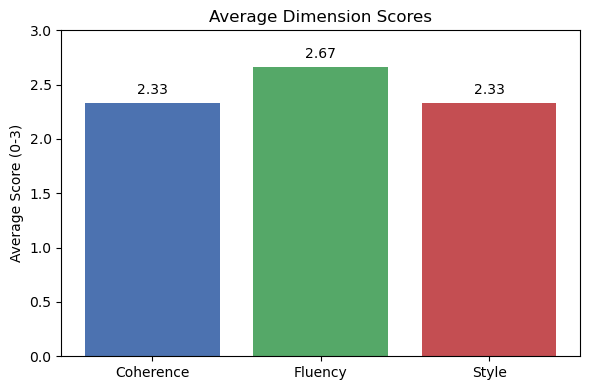

In [83]:
import matplotlib.pyplot as plt

avg_scores = gpt5nano_judge_noref[[
    "coherence_relevance",
    "fluency_readability",
    "style_appropriateness"
]].mean().rename({
    "coherence_relevance": "Coherence",
    "fluency_readability": "Fluency",
    "style_appropriateness": "Style"
})

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(avg_scores.index, avg_scores.values, color=["#4C72B0", "#55A868", "#C44E52"])
ax.set_ylim(0, 3)
ax.set_ylabel("Average Score (0-3)")
ax.set_title("Average Dimension Scores")
for idx, val in enumerate(avg_scores.values):
    ax.text(idx, val + 0.05, f"{val:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


In [97]:
gpt5nano_judge_noref.iloc[4]

set_id                                                                P_R1.xlsx
prompt_id                                                                     4
model                                                                 P_R1.xlsx
run                                                                           1
coherence_relevance                                                           0
fluency_readability                                                           1
style_appropriateness                                                         1
total                                                                         2
coherence_relevance_expl      The user input is about salmon and a large amo...
fluency_readability_expl      Most sentences are grammatical, but the final ...
style_appropriateness_expl    The tone attempts to be medical/professional a...
prompt_text                   I ate salmon and took 2 liters of alcohol at 5...
output                        ✅ I logged

In [104]:
gpt5nano_judge_noref_v2 = gpt5nano_judge_noref.drop(gpt5nano_judge_noref.index[4])
gpt5nano_judge_noref_v2 = gpt5nano_judge_noref_v2.head(11)

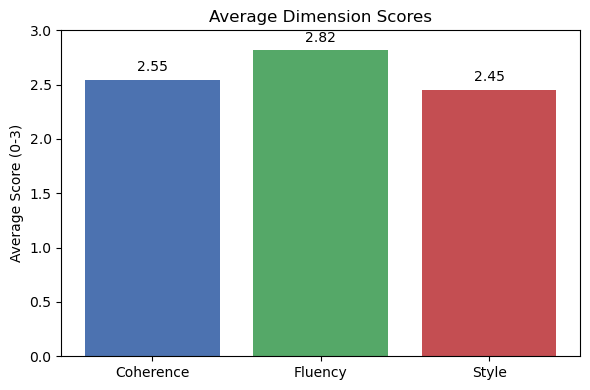

In [105]:
avg_scores = gpt5nano_judge_noref_v2[[
    "coherence_relevance",
    "fluency_readability",
    "style_appropriateness"
]].mean().rename({
    "coherence_relevance": "Coherence",
    "fluency_readability": "Fluency",
    "style_appropriateness": "Style"
})

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(avg_scores.index, avg_scores.values, color=["#4C72B0", "#55A868", "#C44E52"])
ax.set_ylim(0, 3)
ax.set_ylabel("Average Score (0-3)")
ax.set_title("Average Dimension Scores")
for idx, val in enumerate(avg_scores.values):
    ax.text(idx, val + 0.05, f"{val:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()